# Particle marginal Metropolis-Hastings (PMMH)

Notebook about testing PMMH.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# Add parent directory to sys.path
print(os.getcwd())
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

d:\School\Fakulteta\2. stopnja\2. letnik\Master\notebooks


In [2]:
from src.models.lgm import LGModelParams, LGModel
from src.filters.kalman.kalman_filter import KalmanFilter
from src.filters.pmcmc.pmmh import ParticleMarginalMetropolisHastings
from src.filters.smc.bootstrap_pf import BootstrapParticleFilter
from src.filters.smc.resampling import systematic_resampling
from src.data_generation.simulate_data import simulate_data

In [3]:
# Set random seed for reproducibility
rng = np.random.default_rng(123)

# True parameters
true_theta = LGModelParams(
    a=0.7,
    b=1.0,
    sigma_x=1.0,
    sigma_y=0.5,
)

# Initialize model
model = LGModel(rng=rng)

In [4]:
T = 100

x_true, y = simulate_data(model, true_theta, T, rng)

In [5]:
x_true = [x.x_t for x in x_true]  # Extract state values from State objects
x_true = np.array(x_true)
print(x_true.shape)
print(y.shape)

(100, 1)
(100, 1)


In [6]:
N = 1000

bpf = BootstrapParticleFilter(model, N, resampler=systematic_resampling)

In [7]:
kwargs_for_sampling = {
    "step_a": 0.01,
    "step_b": 0.01,
    "step_sigma_x": 0.03,
    "step_sigma_y": 0.03,
}
    
pmmh = ParticleMarginalMetropolisHastings(bpf, kwargs_for_sampling=kwargs_for_sampling)

In [8]:
logliks = []
for _ in range(50):
    history = bpf.run(y, true_theta)
    logliks.append(history[-1][3])

np.mean(logliks), np.std(logliks)

(np.float64(-155.73604907978023), np.float64(0.5156761209715023))

In [9]:
# Compute kalman filter log-likelihood for comparison
kf = KalmanFilter()
kf_loglik = kf.log_marginal_likelihood(y, true_theta)
print(kf_loglik)

-155.50211778012053


In [10]:
samples, logmarliks, thetas, alphas = pmmh.run(y, n_iter=2000, burnin=0, verbose=True)

Iteration 100/2000 - Acceptance Rate: 0.818
Iteration 200/2000 - Acceptance Rate: 0.824
Iteration 300/2000 - Acceptance Rate: 0.833
Iteration 400/2000 - Acceptance Rate: 0.827
Iteration 500/2000 - Acceptance Rate: 0.838
Iteration 600/2000 - Acceptance Rate: 0.846
Iteration 700/2000 - Acceptance Rate: 0.850
Iteration 800/2000 - Acceptance Rate: 0.847
Iteration 900/2000 - Acceptance Rate: 0.848
Iteration 1000/2000 - Acceptance Rate: 0.845
Iteration 1100/2000 - Acceptance Rate: 0.849
Iteration 1200/2000 - Acceptance Rate: 0.845
Iteration 1300/2000 - Acceptance Rate: 0.843
Iteration 1400/2000 - Acceptance Rate: 0.848
Iteration 1500/2000 - Acceptance Rate: 0.846
Iteration 1600/2000 - Acceptance Rate: 0.846
Iteration 1700/2000 - Acceptance Rate: 0.838
Iteration 1800/2000 - Acceptance Rate: 0.840
Iteration 1900/2000 - Acceptance Rate: 0.840
Iteration 2000/2000 - Acceptance Rate: 0.843


In [11]:
print(samples.shape)    # (n_iter, T+1)
print(logmarliks.shape)  # (n_iter,)

(2000, 101)
(2000,)


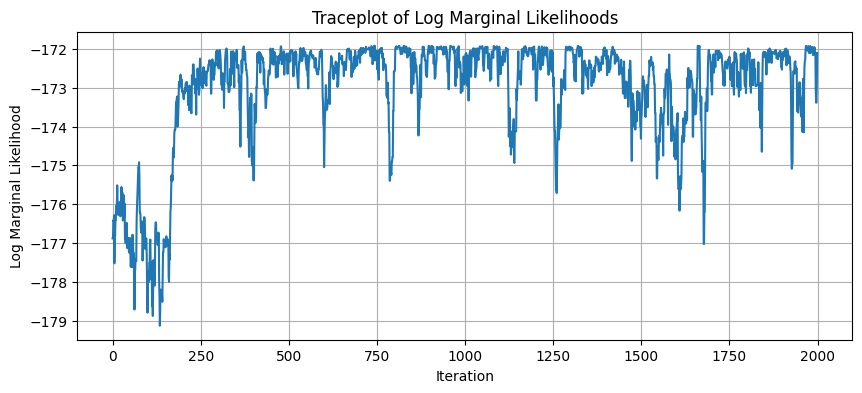

In [12]:
# Traceplot of log marginal likelihoods
plt.figure(figsize=(10, 4))
plt.plot(logmarliks)
plt.title('Traceplot of Log Marginal Likelihoods')
plt.xlabel('Iteration')
plt.ylabel('Log Marginal Likelihood')
plt.grid()
plt.show()

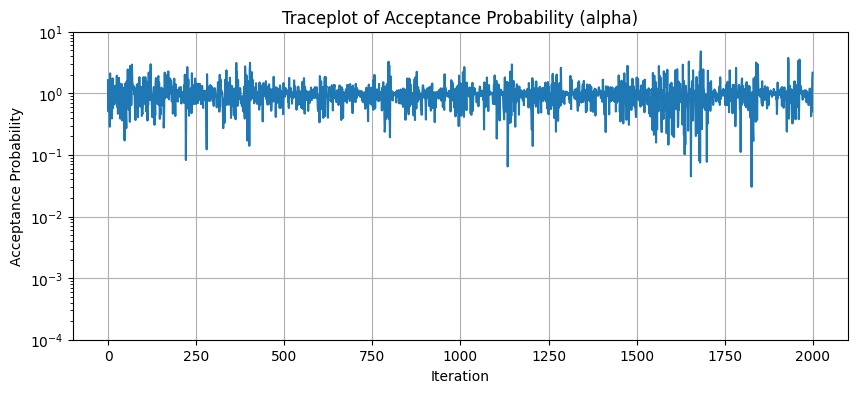

In [13]:
# Traceplot of acceptance probability alpha
plt.figure(figsize=(10, 4))
plt.plot(alphas)
plt.title('Traceplot of Acceptance Probability (alpha)')
plt.xlabel('Iteration')
plt.ylabel('Acceptance Probability')
plt.yscale('log')
plt.ylim(1e-4, 10)
plt.grid()
plt.show()


In [14]:
# Discard first couple of samples as burn-in
burnin = 0
samples_post_burnin = samples[burnin:]
logmarliks_post_burnin = logmarliks[burnin:]
thetas_post_burnin = {key: np.array(vals[burnin:]) for key, vals in thetas.items()}

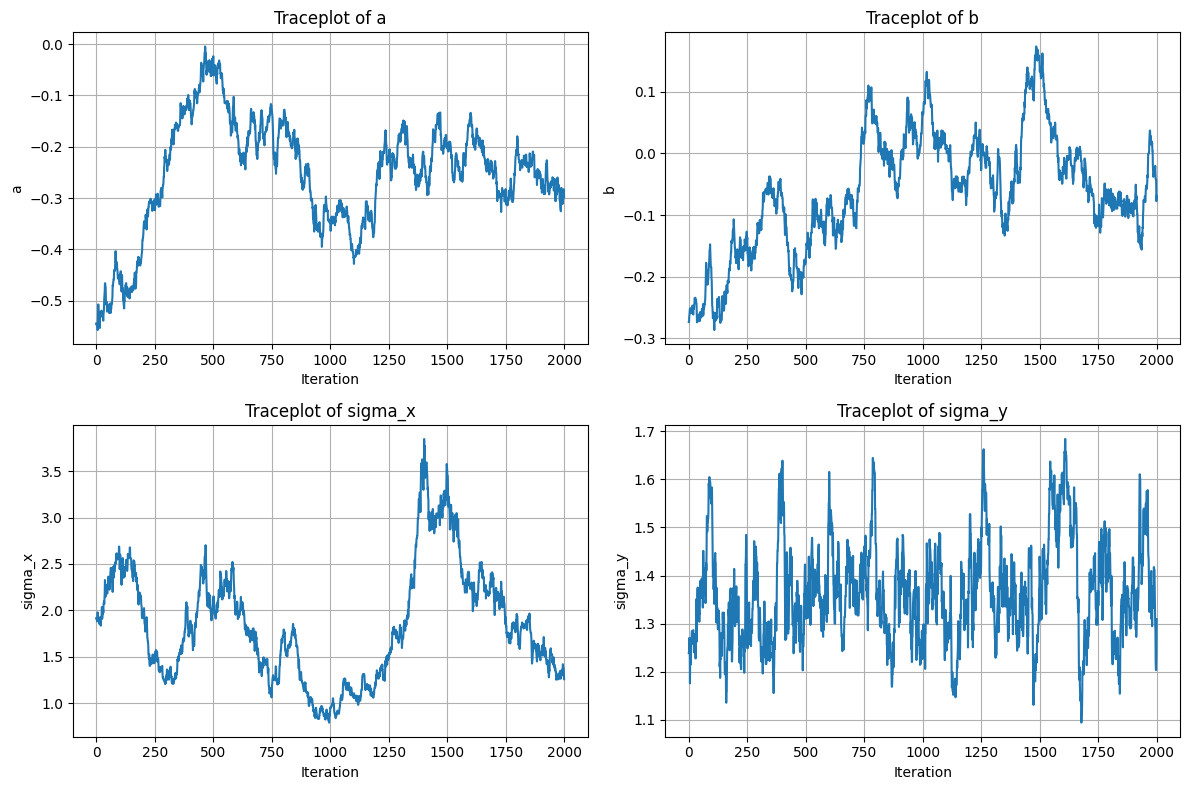

In [15]:
# Traceplot of parameters
plt.figure(figsize=(12, 8))
for i, key in enumerate(thetas_post_burnin.keys()):
    plt.subplot(2, 2, i+1)
    plt.plot(thetas_post_burnin[key])
    plt.title(f'Traceplot of {key}')
    plt.xlabel('Iteration')
    plt.ylabel(key)
    plt.grid()
plt.tight_layout()
plt.show()